Normalized confusion matrix
[[9.96e+01 1.06e-01 1.59e-01 0.00e+00 5.29e-02 0.00e+00 0.00e+00 0.00e+00
  5.29e-02 5.29e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 9.39e+01 6.12e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.45e+00 3.15e+00 8.74e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [3.12e-01 0.00e+00 0.00e+00 9.91e+01 6.23e-01 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [1.85e+00 0.00e+00 0.00e+00 6.15e-01 9.75e+01 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [2.44e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.76e+01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+02 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00

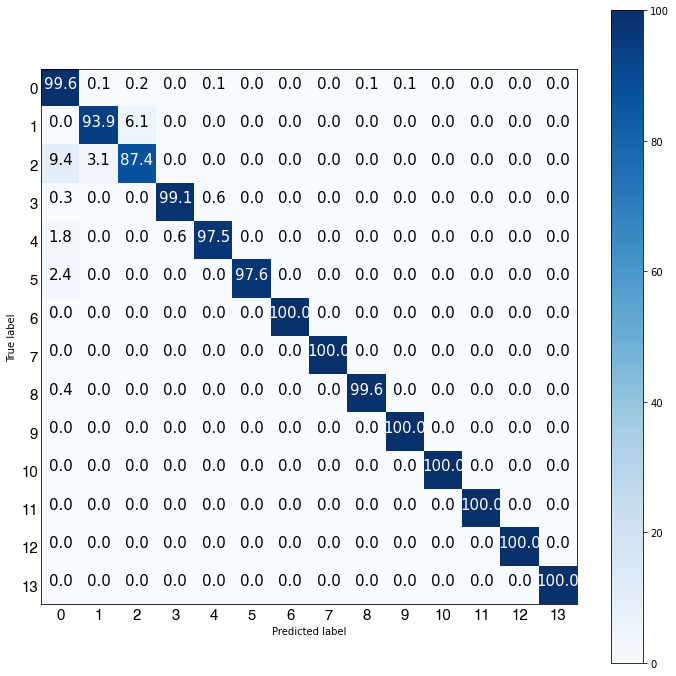

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from joblib import Parallel,delayed
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
import itertools

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def plot_confusion_matrix(cm, classes,
                          normalize=False,fontsize=18,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm * 100
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15, fontname = "Helvetica")
    plt.yticks(tick_marks, classes, fontsize=15, fontname = "Helvetica")
    plt.tick_params(direction='in', length=8, width=0, colors='black')
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.random.seed(42)

np.set_printoptions(precision=2)
fnames=sorted(glob('Data_Pathway/*'))
files=[np.loadtxt(f) for f in fnames]
map=[f[:,3] for f in files]
map=[np.reshape(m,(-1,1011)) for m in map]
map_full = np.concatenate([m[:,:] for m in map],axis=0)

y = np.concatenate([np.repeat(i, len(m)) for i, m in enumerate(map)], axis=0)
map_full= savgol_filter(map_full, 11, 3, axis=0)
back = Parallel(n_jobs=8)(delayed(baseline_als)(j, 100000, 0.001) for j in map_full)
map_full= np.subtract(map_full, back)
map_full= np.reshape(map_full, (-1, 1011))
divide=map_full[:,999:1000] # Si peak normolization
X=map_full/divide

X_tra, X_test, y_tra, y_test = train_test_split(X,y,test_size=0.2,stratify=y, shuffle=True)


pca = PCA(n_components=22)
pca.fit(X_tra)
X_tra= pca.transform(X_tra)
    
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_tra, y_tra)
    
svc = SVC()
svc.fit(X_train_res, y_train_res)

#'0'=control class, '1'=5 fM, '2'=50 fM, '3'=0.5 pM,'4'=5 pM,'5'=50 pM,'6'=0.5 nM,'7'=5 nM, '8'=50 nM, '9'=0.5uM, 
#'10'=5 uM,'11'=50 uM,'12'=0.5 mM,'13'=5 mM
class_names=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11','12','13']

x_test_pca= pca.transform(X_test)
y_predict = svc.predict(x_test_pca)
# Compute confusion matrix
cn_matrix = confusion_matrix(y_predict,y_test)
# Plot normalized confusion matrix
plot_confusion_matrix(cn_matrix, classes=class_names, normalize=True)